# Optimal feature clustering - Part I
> Feature, or variable, clustering finds several applications in finance: portfolio construction, feature selection, regime detection, etc. Here I describe appropriate metrics for comparing features and show how entropy-minimization arguments allow for optimal clustering.

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [Clustering, Entropy, Membership Entropy, Feature Selection, Variation of Information, Correlation Distance]
- image: images/___________.png
- hide: false
- search_exclude: false
- author: Joao Rodrigues

## Introduction

Here, I will address the problem of clustering, specifically feature (or variable) clustering. Feature clustering appears in several processes associated with finance and systematic trading, including portfolio construction, feature selection, etc.

I will use the fuzzy clustering framework to develop some of the ideas. Here, instead of assigning each point in the feature space to a definite cluster, a set of membership probabilities $p_x(i)$ are calculated, describing the degree of confidence in assigning point $x$ to cluster $i$.

As with many other clustering techniques, a fundamental problem is to infer the optimal number of clusters, which enters as a free parameter in many of the respective algorithms. I will show that a by-product of the probabilistic nature of the fuzzy clustering framework, we can define information-theoretic measures on the quality of the clustering and use an entropy minimization argument to infer the optimal number of clusters. I have originally developed these ideas in the context of data-driven detection of phases and phase transitions in physical systems made up of only a few particles{% cite Rodrigues2020 %}.

In the context of feature clustering, appropriate metrics have to be used to correctly calculate the "distance" between pairs of variables. I will discuss correlation-based and information-theoric-based metrics here as well.

Finally, I am going to describe how to build an observation matrix and conduct the clustering process over a *feature space of features*.

In **Part II**, published in a separate post, I will conduct controlled numerical experiments and analyse the performance of the framework described in this **Part I**.

**Note:** While the discussion here will be centred around clustering of features, some of the techniques and ideas are completely general and applicable in many other applications involving clustering.

## Optimal clustering 

As mentioned before, within the framework of fuzzy clustering, $p_x(i)$ is the probability of element $x$ - either a feature itself, or an observation in a given feature space, in general - belonging to cluster $i$, with $i=1,2,...,k$ and $k$ the total number of clusters. Here, I will estimate these probabilities using the fc-means algorithm {% cite Bezdek2013 %}, implemented in the Python package *fcmeans* {% cite Dias2019 %}.

From the probabilities $p_x(i)$, we can define the membership entropy

$$S_x(\{ p_x(i) \}) = - \frac{1}{\mathrm{log}(k)} \displaystyle\sum_{i=1}^k p_x(i) \mathrm{log}(p_x(i)),$$

which quantifies the ambiguity in assigning observation $x$ to the available clusters. The least ambiguous case corresponds to $p_x(j) = 1$ and $p_x(i\neq j)=0$ for a given cluster $j$, with $S_x=0$. On the other hand, a maximally ambiguous such that $p_x(i) = 1/k$, with maximum membership entropy $S_x=1$. 

Note that, the $1/\mathrm{log}(k)$ in the equation above normalizes the membership entropy, such that configurations with different numbers of clusters can be correctely compared. This will be used later to infer the optimal number of clusters

Lastly, we define the representative cluster as that that, for a given observation $x$, maximizes the subset of probabilities $p_x(i)$. It is thus the most representative cluster associated with $x$.

In [68]:
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('text', usetex = True)
font = {'family': 'normal', 'size': 12}
matplotlib.rc('font', **font)
matplotlib.rcParams['figure.dpi']= 700

In [5]:
#collapse-show


#
#
#
# Review and clean this code

from fcmeans import FCM

def cluster(n_clusters, features):
    # clustering
    model = FCM(n_clusters=n_clusters).fit(features)
    p = model.u
    
    # membership entropy
    membership_entropy = np.zeros(features.shape[0])
    for i in range(0, features.shape[0]):
        aux = 0
        for k in range(0, n_clusters):
            aux += -p[i,k]*np.log(p[i,k])
        membership_entropy[i] = aux
    membership_entropy = membership_entropy / np.log(n_clusters)
    average_membership_entropy = np.mean(membership_entropy)
    
    return p, average_membership_entropy

**Numerical illustration**

**1. Sample dataset:**

In [24]:
#collapse-show
N = 500
n_clusters = 5
blob_centers = [[0,0], [-1.0,1.0], [-1.0, -1.0], [1.0,-1.0], [1.0,1.0]]
blobs_std = [0.2, 0.35, 0.5]

from sklearn.datasets import make_blobs

X_all = list()
y_all = list()
for std in blobs_std:
	X, y = make_blobs(n_samples=N, centers=blob_centers, cluster_std=[std]*n_clusters, n_features=2, random_state=0)
	X_all.append(X)
	y_all.append(y)

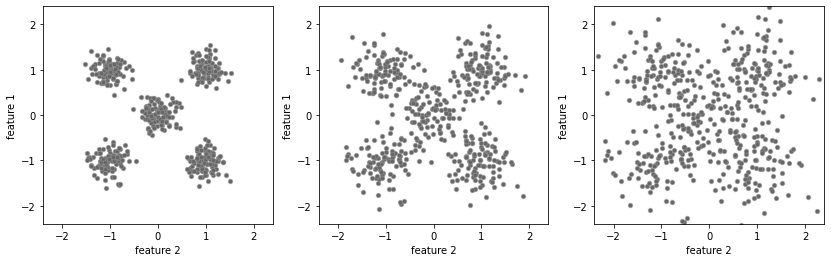

In [40]:
#collapse-hide
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
for i, ax in enumerate(axes):
    ax.scatter(X_all[i][:,0], X_all[i][:,1], marker='.', s=80, edgecolor=(0.6,0.6,0.6,0.5), facecolor=(0.4,0.4,0.4))
    ax.set_ylabel('feature 1')
    ax.set_xlabel('feature 2')
    ax.set_xlim([-2.4, 2.4])
    ax.set_ylim([-2.4, 2.4])
    ax.set_xticks([-2, -1, 0, 1, 2])
    ax.set_yticks([-2, -1, 0, 1, 2])
plt.show()

**2. Membership entropy:**

In [26]:
#collapse-show

#
#
#
# review and clean
n_clusters_trials = np.arange(2, 10, 1)
membership_entropy_all = list()
for X in X_all:
    membership_entropy = list()
    for n in n_clusters_trials:
        _, average_membership_entropy = cluster(n_clusters=n, features=X)
        membership_entropy.append(average_membership_entropy)
    membership_entropy_all.append(membership_entropy)


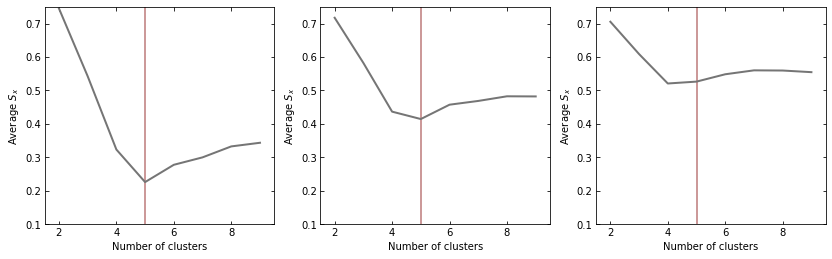

In [27]:
#collapse-hide
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
for i, ax in enumerate(axes):
    ax.plot([5, 5], [0, 1], color=(0.8,0.6,0.6), linewidth=2)
    ax.plot(n_clusters_trials, membership_entropy_all[i], color=(0.46,0.46,0.46), linewidth=2)
    ax.set_xlabel('Number of clusters', )
    ax.set_ylabel('Average $S_x$')
    ax.tick_params(axis="both")
    ax.tick_params(direction='in', bottom=True, top=True, left=True, right=True)
    ax.set_xlim([1.5, 9.5])
    ax.set_xscale('linear')
    ax.set_yscale('linear')
    ax.set_ylim(0.10, 0.75)
plt.show()

Note: Intercluster mean membership entropy as a measure of quality of cluster

mention that solution depends on initial condition, so better significance could be obtained by doing ensemble runs with different seeds

## Distance metrics

**1. Correlation distance (two-sided)**: $ d_\rho (X, Y) = \sqrt{(1-\rho(X,Y))/2} $

**2. Correlation distance (one-sided)**: $ d_{\vert \rho \vert} = \sqrt{1 - \vert \rho(X,Y) \vert} $

**3. Variation of information**: $d_I(X,Y) = 1 - \frac{I(X,Y)}{S(X,Y}$

All three quantities are true metrics, in the sense that they satisfy all the properties required by a metric: non-negativity, symmetry and triangle inequality. They then define a topological structure in this space. Besides, all three metrics are normalized, such that $0 \leq d \leq 1$ (CONFIRM THIS).




Mention other post on mutual information

**1. Correlation distance (two-sided):**

In [34]:
def calculate_corr_distance_2side(X, Y):
    rho = np.corrcoef(np.array((X, Y)))[0,1]
    distance = np.sqrt((1-rho)/2)
    return distance

**2. Correlation distance (one-sided):**

In [35]:
def calculate_corr_distance_1side(X, Y):
    rho = np.corrcoef(np.array((X, Y)))[0,1]
    distance = np.sqrt(1-np.abs(rho))
    return distance

**3. Variation of information:**

In [36]:
#collapse-show
def calculate_entropy(X):
    # 1) Histograms the samples
    nbins = int(len(X)**(1/3))
    p = np.histogram(X, bins=nbins, density=False)[0]
    p = p/np.sum(p)+1e-6
    # 2) Calculates the entropy
    entropy = -np.sum(p*np.log2(p))
    
    return entropy

def calculate_joint_entropy(X, Y):
    # 1) Histograms the samples
    nbins = int(len(X)**(1/3))
    p = np.histogram2d(X, Y, bins=nbins, density=False)[0]
    p = p/np.sum(p)+1e-6
    # 2) Calculates the entropy
    entropy = -np.sum(p*np.log2(p))
    
    return entropy

def calculate_mutual_information(X, Y):
    S_X = calculate_entropy(X)
    S_Y = calculate_entropy(Y)
    S_XY = calculate_joint_entropy(X, Y)
    I = S_X+S_Y-S_XY
    return I

def calculate_variation_of_information(X, Y):
    I = calculate_mutual_information(X, Y)
    S = calculate_joint_entropy(X, Y)
    distance = 1 - I/S
    
    return distance

**Numerical illustration:**

In [37]:
#collapse-show
from scipy.linalg import eigh, cholesky
from scipy.stats import norm

def generate_correlated_samples(N, rho):
    # The desired covariance matrix.
    r = np.array([[1.0, rho],
                 [rho, 1.0]])
    # Generate samples from 2 independent normally distributed N(0,1)
    x = norm.rvs(size=(2, N))
    # Compute the Cholesky decomposition.
    c = cholesky(r, lower=True)
    # Convert the data to correlated random variables. 
    y = np.dot(c, x)
    
    return (y[0,:], y[1,:])

In [38]:
rhos = [0, 0.5, -0.9]
samples = [generate_correlated_samples(N=1000, rho=rho) for rho in rhos]

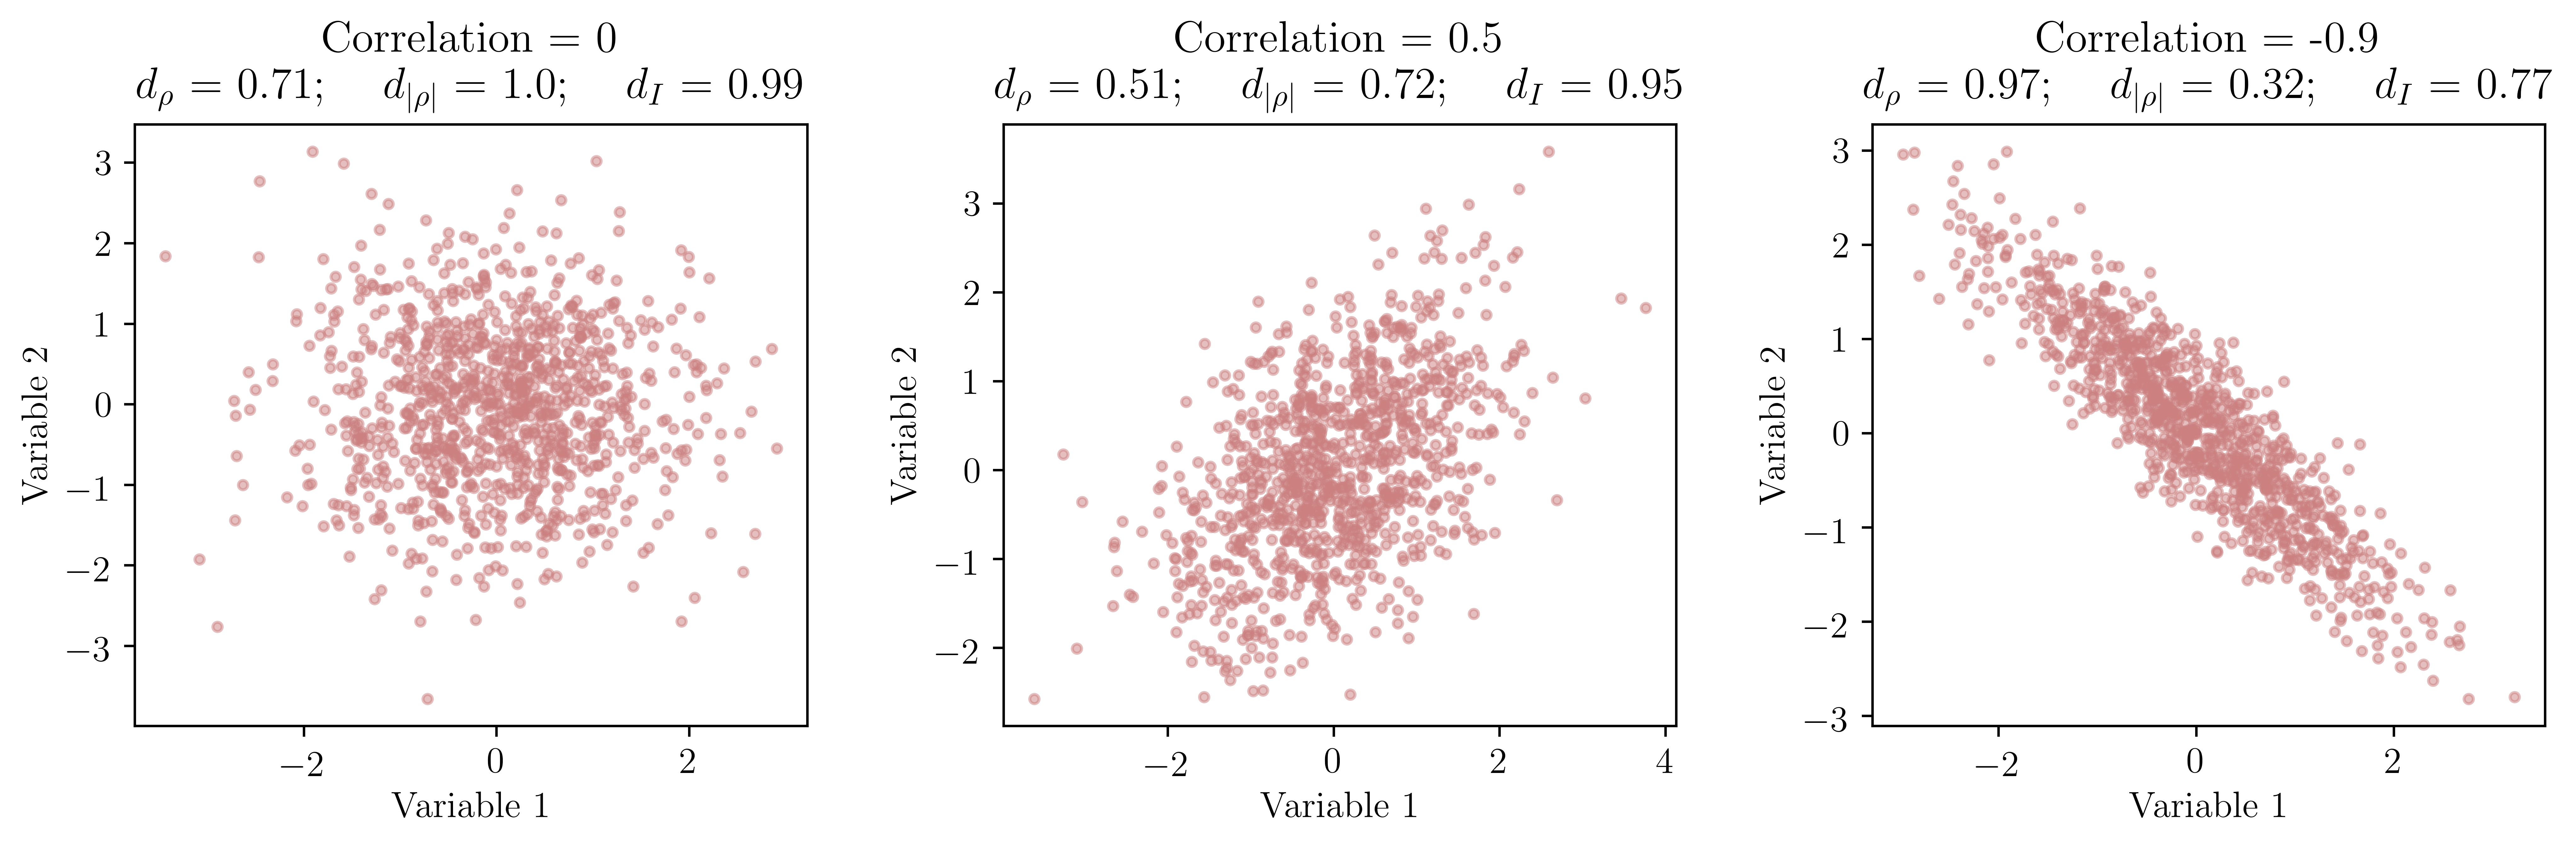

In [39]:
#collapse-hide
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, rho in enumerate(rhos):
    axes[i].plot(samples[i][0], samples[i][1], '.', color=(0.8,0.5,0.5,0.5))
    axes[i].set_xlabel("Variable 1")
    axes[i].set_ylabel("Variable 2")
    axes[i].set_title("Correlation = "+str(rho)+
                      "\n$d_\\rho$ = "+str(np.round(calculate_corr_distance_2side(samples[i][0], samples[i][1]),2))+
                      "; \quad  $d_{\\vert \\rho \\vert}$ = "+str(np.round(calculate_corr_distance_1side(samples[i][0], samples[i][1]),2))+
                      "; \quad  $d_I$ = "+str(np.round(calculate_variation_of_information(samples[i][0], samples[i][1]),2)))
plt.tight_layout()
plt.show()

Now a nonlinear relationship

In [58]:
X = norm.rvs(size=(1, 1000))[0,:]
noise = [0.1, 1.0, 2.0]
samples = [(X, X**2 + value*norm.rvs(size=(1, 1000))[0,:]) for value in noise]

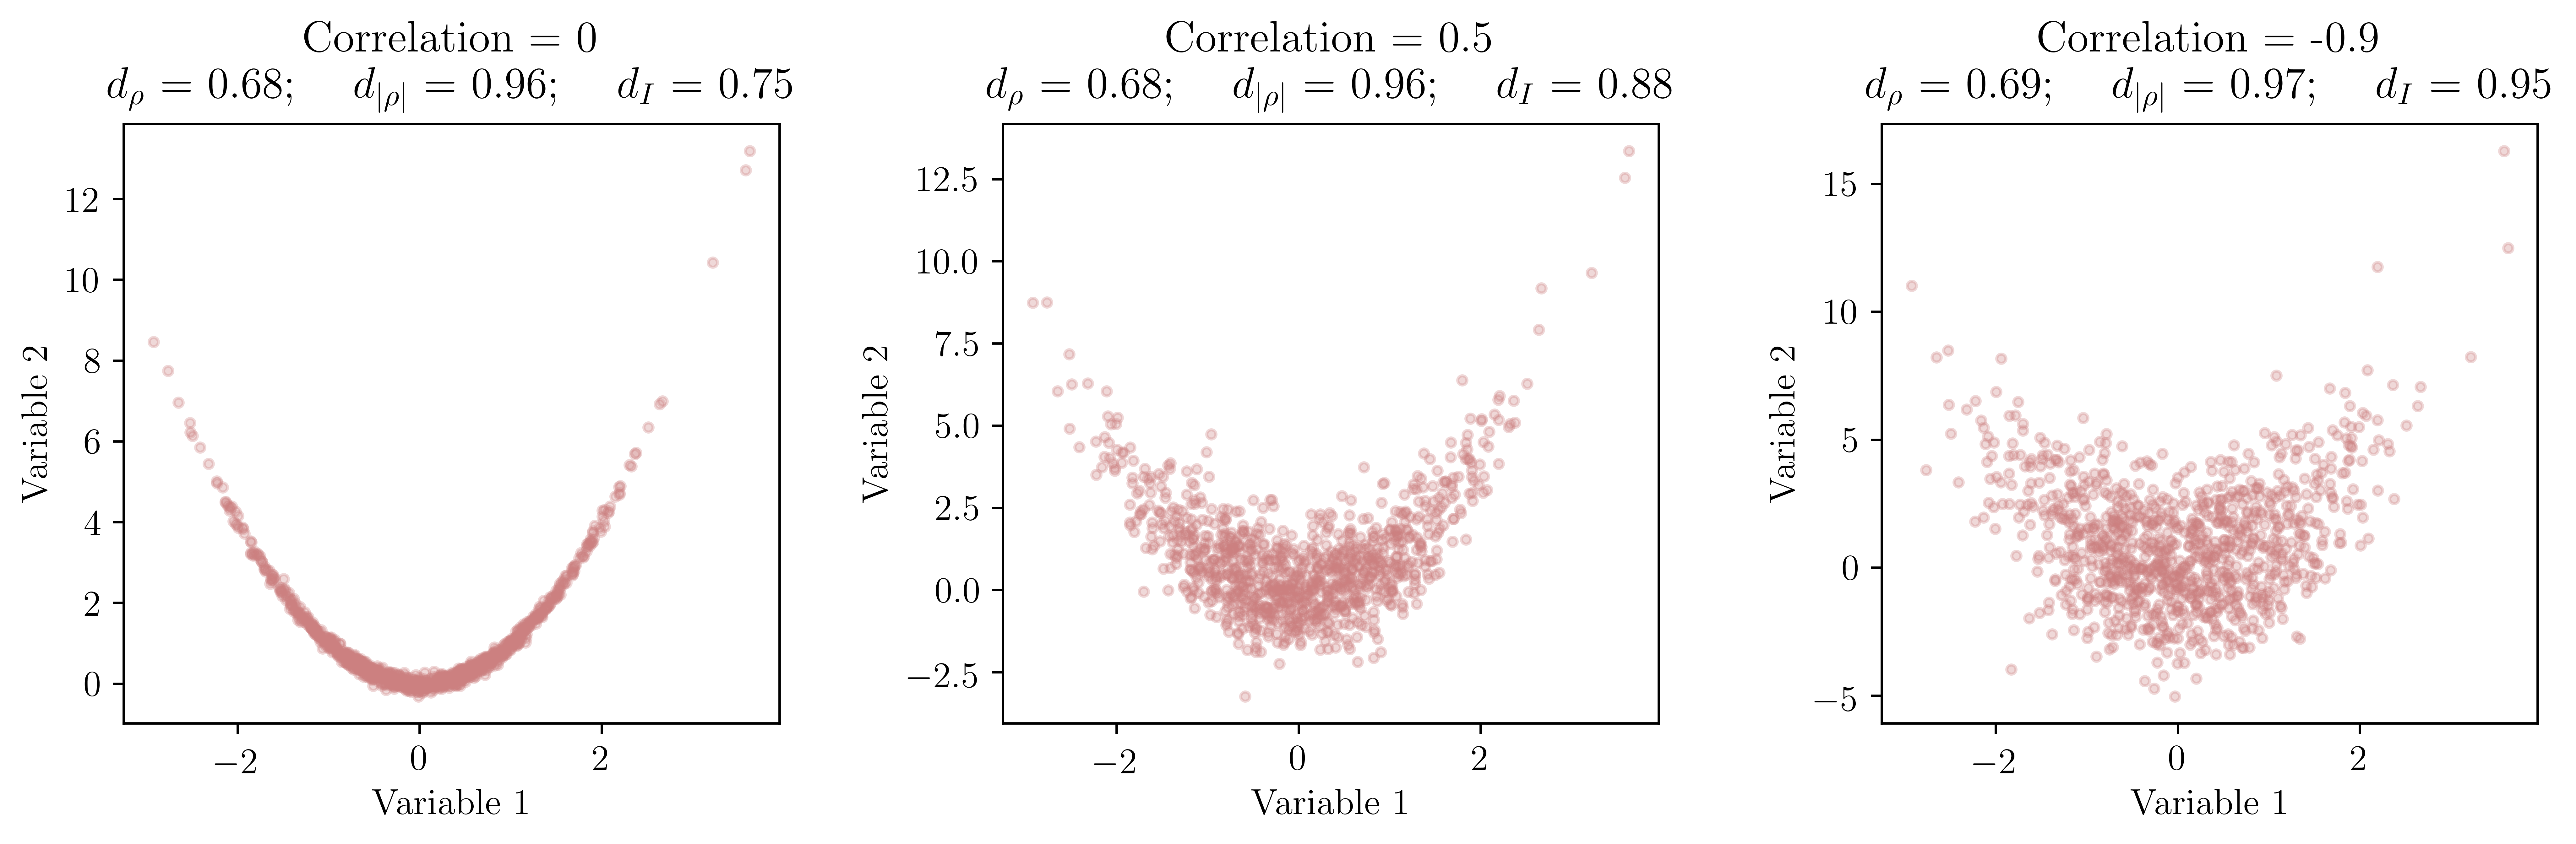

In [59]:
#hide_input
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, rho in enumerate(rhos):
    axes[i].plot(samples[i][0], samples[i][1], '.', color=(0.8,0.5,0.5,0.3))
    axes[i].set_xlabel("Variable 1")
    axes[i].set_ylabel("Variable 2")
    axes[i].set_title("Correlation = "+str(rho)+
                      "\n$d_\\rho$ = "+str(np.round(calculate_corr_distance_2side(samples[i][0], samples[i][1]),2))+
                      "; \quad  $d_{\\vert \\rho \\vert}$ = "+str(np.round(calculate_corr_distance_1side(samples[i][0], samples[i][1]),2))+
                      "; \quad  $d_I$ = "+str(np.round(calculate_variation_of_information(samples[i][0], samples[i][1]),2)))
plt.tight_layout()
plt.show()

Note that, variation of information is still relative high, partially because of the degeneracy in the variables. Knowing Y does not determine X even with zero noise

## Experimental results

In [9]:
from sklearn.utils import check_random_state

def construct_random_partition(n, k, m, random_state=42):
    rng = check_random_state(random_state)
    parts = rng.choice(range(1, n-k*(m-1)), k-1, replace=False)
    parts.sort()
    parts = np.append(parts, n-k*(m-1))
    parts = np.append(parts[0], np.diff(parts)) - 1 + m
    
    return parts

In [16]:
out = construct_random_partition(n=10, k=4, m=2, random_state=42)
print(out)

[3 2 3 2]


**References:**

{% bibliography --cited %}